In [82]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly as px

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df = pd.read_parquet('US-economy.parquet')
scaler = MinMaxScaler((-1,1))
scaled_data = scaler.fit_transform(df)
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df)

# X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Assuming scaled_data is a NumPy array or similar
n_samples = scaled_data.shape[0]
train_size = int(n_samples * 0.8)  # 80% of data for training

X_train = scaled_data[:train_size]
X_test = scaled_data[train_size:]


In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

# Define the dimension of the input data
input_dim = df.shape[1]  # assuming the input data is flattened 28x28 images

# Define the dimension of the latent space
latent_dim = 2
alpha = 0
# Encoder
encoder = Sequential([
    Dense(32, input_shape=(input_dim,), activation='tanh'),
    #LeakyReLU(alpha=alpha),
    Dense(latent_dim, activation='tanh'),
    #LeakyReLU(alpha=alpha),
])

# Decoder
decoder = Sequential([
    Dense(32, input_shape=(latent_dim,), activation='tanh'),
    #LeakyReLU(alpha=alpha),
    Dense(input_dim, activation='linear')
])

# Autoencoder
autoencoder = Sequential([
    encoder,
    decoder
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 2)                 418       
                                                                 
 sequential_19 (Sequential)  (None, 10)                426       
                                                                 
Total params: 844
Trainable params: 844
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = autoencoder.fit(
    X_train, X_train,  # input and target data are the same
    epochs=436,
    batch_size=740,
    shuffle=True,
    validation_data=(X_test, X_test)
)


Epoch 1/436


2023-10-20 23:42:45.997788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.1384

2023-10-20 23:42:47.569001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.1384 - val_loss: 0.1435
Epoch 2/436
1/1 [==============================] - 0s 26ms/step - loss: 0.1315 - val_loss: 0.1369
Epoch 3/436
1/1 [==============================] - 0s 27ms/step - loss: 0.1248 - val_loss: 0.1306
Epoch 4/436
1/1 [==============================] - 0s 24ms/step - loss: 0.1185 - val_loss: 0.1246
Epoch 5/436
1/1 [==============================] - 0s 24ms/step - loss: 0.1123 - val_loss: 0.1188
Epoch 6/436
1/1 [==============================] - 0s 25ms/step - loss: 0.1065 - val_loss: 0.1132
Epoch 7/436
1/1 [==============================] - 0s 23ms/step - loss: 0.1009 - val_loss: 0.1079
Epoch 8/436
1/1 [==============================] - 0s 23ms/step - loss: 0.0956 - val_loss: 0.1028
Epoch 9/436
1/1 [==============================] - 0s 23ms/step - loss: 0.0906 - val_loss: 0.0980
Epoch 10/436
1/1 [==============================] - 0s 24ms/step - loss: 0.0858 - val_loss: 0.0933
Epoch 11/436
1/1 [===============

5/5 [==============================] - 0s 4ms/step - loss: 0.0193
Reconstruction error: 0.019305812194943428


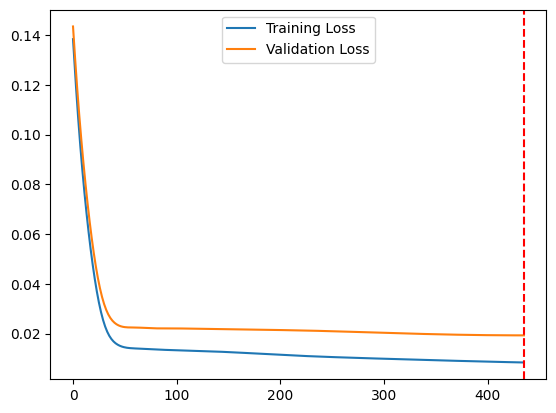

min val loss iterations: 435


In [97]:
reconstruction_error = autoencoder.evaluate(X_test, X_test)
print(f'Reconstruction error: {reconstruction_error}')
min_loss = np.argmin(history.history['val_loss'])
# Optionally visualize the loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(min_loss,c='r',linestyle='--')
plt.legend()
plt.show()

print('min val loss iterations:',min_loss)


In [98]:
encoded_data = encoder.predict(scaled_data)

 1/24 [>.............................] - ETA: 0s

24/24 [==============================] - 0s 2ms/step


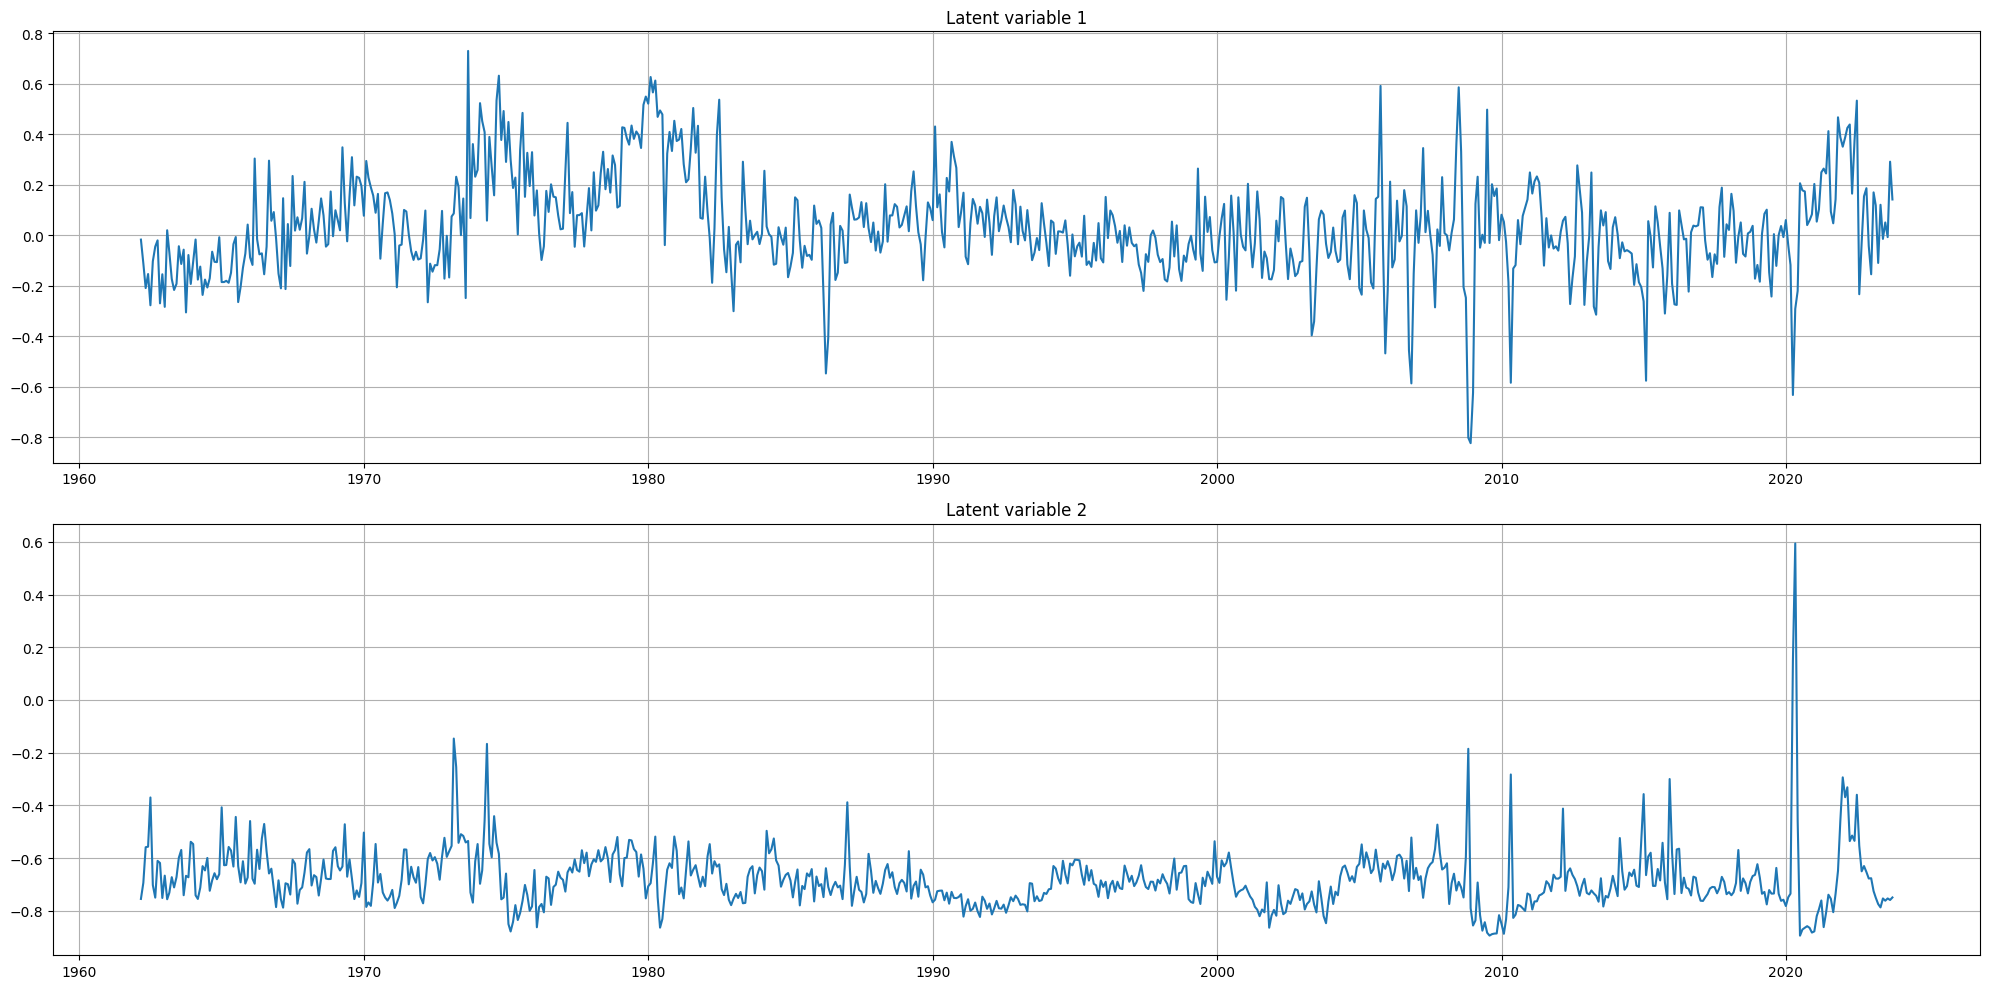

In [99]:
# Plot each time series in a separate subplot
fig, axes = plt.subplots(nrows=encoded_data.shape[1], ncols=1, figsize=(20, 10))

for i in range(encoded_data.shape[1]):
    axes[i].plot(df.index, encoded_data[:,i])
    axes[i].set_title(f'Latent variable {i+1}')
    axes[i].grid(True)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [100]:
latent = pd.DataFrame(encoded_data)
Z = np.load('states.npy')
states = pd.Series(Z).rename('states')

In [102]:
latent.describe()

,0,1
count,740.000000,740.000000
mean,0.033927,-0.681135
std,0.194905,0.112779
min,-0.823500,-0.894214
25%,-0.084750,-0.746628
50%,0.015828,-0.694880
75%,0.128539,-0.635584
max,0.729712,0.593878


[]

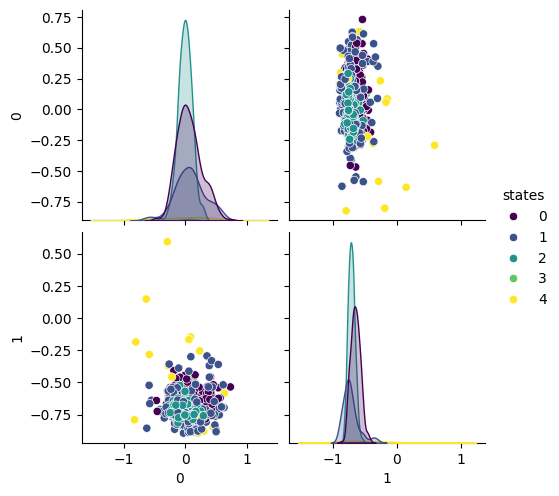

In [103]:
sns.pairplot(pd.concat([latent,states],axis=1), hue='states',palette='viridis')
plt.plot()

In [104]:
if encoded_data.shape[1] < 3:
    print("The latent space does not have 3 dimensions!")
else:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2])

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    plt.show()

The latent space does not have 3 dimensions!


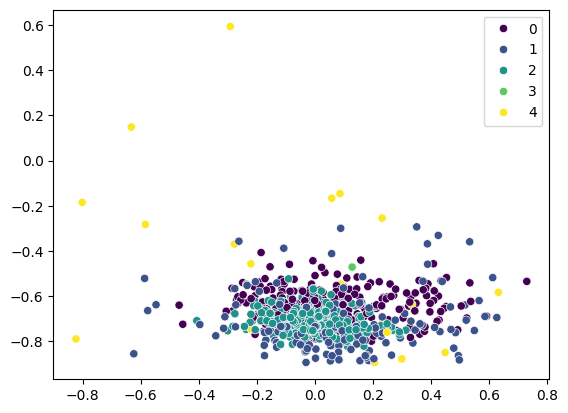

In [105]:
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=Z,palette='viridis')
plt.show()

In [96]:
import plotly.express as px
# Create the scatter plot for the data
fig = px.scatter_3d(x=encoded_data[:, 0], y=encoded_data[:, 1], z=encoded_data[:, 2], color=Z)
fig.update_traces(marker=dict(size=2))

fig.show()

IndexError: index 2 is out of bounds for axis 1 with size 2